In [1]:
%config IPCompleter.greedy = True

In [2]:
import random
import gym
import numpy as np
import time
from gym.envs.registration import register
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
register(
        id = 'FrozenLakeNoSlip-v0',
        entry_point = 'gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name': '4x4', 'is_slippery':False},
        max_episode_steps=100,
        reward_threshold=0.78 # optimum = .8196
        )

env_name = "FrozenLakeNoSlip-v0"

In [4]:
env = gym.make(env_name)

print("Observation space -> ", env.observation_space)
print("Action space -> ", env.action_space)
print("Type of action ->", type(env.action_space))

Observation space ->  Discrete(16)
Action space ->  Discrete(4)
Type of action -> <class 'gym.spaces.discrete.Discrete'>


In [5]:
class Agent:
    
    def __init__(self, env):
        self.is_discrete = \
            type(env.action_space) == gym.spaces.discrete.Discrete
        
        self.state_size = env.observation_space.n
        print("State size:", self.state_size)
        
        if self.is_discrete:
            self.action_size = env.action_space.n
            print("Enviroment is Discrete and Action size is ", self.action_size)
            
        else:
            print("Environment is Continuous")
            
            self.action_low = env.action_space.low
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape
            print("self.action_low ->", self.action_low)
            print("self.action_high ->", self.action_high)
            print("self.action_shape ->", self.action_shape)
            
    def get_action(self, state):
        
        if self.is_discrete:
            action = random.choice(range(self.action_size))
        else:
            action = np.random.uniform(self.action_low,
                                      self.action_high,
                                      self.action_shape)
            
        return action

In [6]:
class Q_Agent(Agent):
    def __init__(self, env, discount_rate=0.97, learning_rate=0.01):
        super().__init__(env)
        
        self.eps = 1.0
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.build_model()
        
        print("discount_rate:", discount_rate)
        print("learning_rate :", learning_rate)
        
    def build_model(self):
        self.Q_table = 1e-4 * np.random.random([self.state_size, self.action_size])
        
    def get_action(self, state):
        Q_current = self.Q_table[state]
        action_greedy = np.argmax(Q_current)
        action_random = super().get_action(state)
        
        if random.random() < self.eps:
            return action_random
        else:
            return action_greedy
        
    def train(self, experience):
        state, action, reward, next_state, done = experience
        
        Q_next = self.Q_table[next_state]
        
        if done:
            Q_next = np.zeros([self.action_size])
            
        self.Q_table[state, action] = (1 - self.learning_rate) * self.Q_table[state, action] + \
        self.learning_rate * (reward + self.discount_rate * np.max(Q_next))
        
        if done:
            self.eps = self.eps * 0.99

In [7]:
Q_agent = Q_Agent(env)
total_reward = 0
total_reward_list = list()
episodes = 1000

for episode in range(episodes):
    
    total_reward_list.append(total_reward)
    state = env.reset()
    
    print(f"Entering Episode {episode}")
    print(f"Total Reward is {total_reward}")
    
    done = False 
    
    while not done:
        
        action = Q_agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        experience = (state, action, reward, next_state, done)
        print(f"Action {action} led the agent to move from state {state} to state {next_state}. Reward={reward}. Done? {done}")
        
        Q_agent.train(experience)
        
        state = next_state
        
        total_reward = total_reward + reward
        
        print(f"Episode: {episode}, Total reward: {total_reward}, eps: {Q_agent.eps}")
        print("---------------------------------------------------------------------")
        print(f"\n", Q_agent.Q_table)
        print("---------------------------------------------------------------------")
        
        env.render()
        clear_output(wait=True)

Action 2 led the agent to move from state 14 to state 15. Reward=1.0. Done? True
Episode: 999, Total reward: 841.0, eps: 4.317124741065784e-05
---------------------------------------------------------------------

 [[4.90207956e-04 7.25595037e-01 6.97080738e-05 5.24512965e-03]
 [2.26107598e-04 1.97874324e-05 6.34354969e-05 6.64521573e-05]
 [5.71598735e-05 8.03953728e-05 2.06792527e-05 3.94830370e-05]
 [4.51934629e-05 1.46416744e-05 5.76592439e-05 5.93681896e-05]
 [1.51589589e-03 8.16465242e-01 3.13269236e-05 7.78636233e-03]
 [2.83547831e-05 4.26906830e-05 2.63177443e-07 7.79676664e-05]
 [6.42189715e-05 3.27597329e-05 5.42166547e-05 5.90127171e-05]
 [5.82783741e-06 6.99531631e-05 8.05700224e-05 5.23432696e-05]
 [5.93080623e-05 4.00621950e-05 8.83764774e-01 7.17266268e-04]
 [6.51603043e-03 9.31675413e-01 1.71648231e-03 3.01360795e-05]
 [2.79641431e-05 6.12307600e-02 3.95290867e-05 5.36731320e-05]
 [4.33960185e-05 5.79525705e-05 3.41882861e-05 4.05653172e-05]
 [5.28034504e-06 6.71785710e-

In [8]:
def analysis_tool(episode_length, total_reward):
    fig, ax = plt.subplots()
    x = np.linspace(0, episode_length, num=episode_length)
    y = total_reward
    
    ax.plot(x,y)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    
    ax.set_ylim(0, episode_length)
    ax.set_title('Accumulate Total Rewards')
    ax.grid()

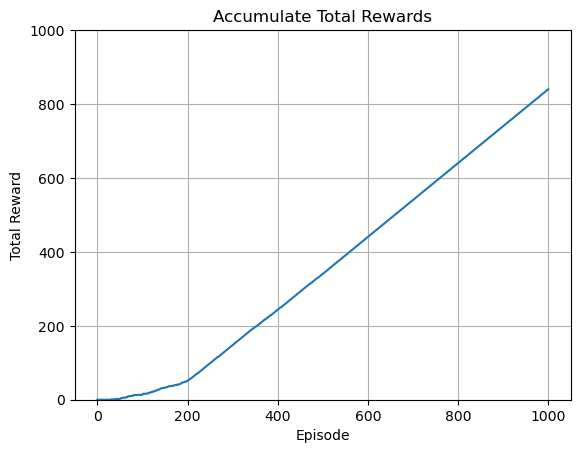

In [9]:
analysis_tool(episodes, total_reward_list)